In [1]:
import warnings                   
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

to_scrap = ['https://www.data.gouv.fr/fr/datasets/r/9ae80de2-a41e-4282-b9f8-61e6850ef449', 'https://www.data.gouv.fr/fr/datasets/r/4b13bbf2-4185-4143-92d3-8ed5d990b0fa']
database = ['NOMS', 'PRENOMS']
nb_min   = 100

for i in range(len(to_scrap)):
    db = pd.read_csv(to_scrap[i], sep = ',')
    db.columns = ['NOM', 'NOMBRE']
    db = db[db.NOMBRE >= nb_min]
    db.to_csv('%s.csv' %database[i])

In [3]:
import numpy as np

col1     = ['NOM', 'PRENOM', 'MAIL', 'ENFANTS', 'CSP']
client   = pd.DataFrame(columns = col1)
taille   = 20000

noms     = pd.read_csv('NOMS.csv')
noms     = noms.NOM
nom_pos  = np.random.randint(len(noms) - 1, size = taille)
nom_sim  = [noms[i] for i in nom_pos]

prenoms  = pd.read_csv('PRENOMS.csv')
prenoms  = prenoms.NOM
pre_pos  = np.random.randint(len(prenoms) - 1, size = taille)
pre_sim  = [prenoms[i].capitalize() for i in pre_pos]

csp      = np.random.rand(taille)
repart   = [csp < 0.01, (csp >= 0.01) & (csp < 0.06), (csp >= 0.06) & (csp < 0.19), (csp >= 0.19) & (csp < 0.32), (csp >= 0.32) & (csp < 0.40), (csp >= 0.40) & (csp < 0.58), (csp >= 0.58) & (csp < 0.88), csp >= 0.88]
csp_list = ['Agriculteur', 'Artisan et apparentés', 'Cadre', 'Profession intermédiaire', 'Employé', 'Ouvrier', 'Retraité', 'Étudiant']
csp_sim  = np.select(repart, csp_list, 'Non renseigné')

client['NOM']     = nom_sim
client['PRENOM']  = pre_sim
client['MAIL']    = client['PRENOM'].apply(str.lower).str.replace(' ', '-') + '.' + client['NOM'].apply(str.lower).str.replace(' ', '') + '@gmail.com'
client['ENFANTS'] = np.random.binomial(12, 0.1, taille)
client['CSP']     = csp_sim


In [4]:
import hashlib

client['ID'] = client['MAIL'].apply(lambda x: hashlib.sha256(x.encode()).hexdigest())
anonyme      = client[['ID', 'ENFANTS', 'CSP']]
client.to_csv('Base de données clients complète.csv')
anonyme.to_csv('Base de données clients anonymisée.csv')

In [5]:
ID = []

for client_id in anonyme['ID']:
    ID.extend([client_id for i in range(np.random.binomial(5, 0.1, 1)[0])])

In [6]:
import random

collecte = random.sample(range(10000000, 99999999), len(ID))
prix     = abs(np.random.normal(70, 10, len(ID)).round(2))
col2     = ['COLLECTE', 'PRIX', 'ID']
achats   = pd.DataFrame(columns = col2)
achats['COLLECTE'] = collecte
achats['PRIX']     = prix
achats['ID']       = ID
achats.sort_values(by = ['COLLECTE'], ignore_index = True, inplace = True)
achats.to_csv('Base de données achats.csv')


In [7]:
x1 = np.random.rand(len(ID))
x2 = np.random.rand(len(ID))
x3 = np.random.rand(len(ID))
x4 = np.random.rand(len(ID))

details = achats[['COLLECTE', 'PRIX']]
details['ALIMENTAIRE'] = (x1 * details['PRIX'] / (x1 + x2 + x3 + x4)).round(2)
details['VETEMENTS']   = (x2 * details['PRIX'] / (x1 + x2 + x3 + x4)).round(2)
details['MAISON']      = (x3 * details['PRIX'] / (x1 + x2 + x3 + x4)).round(2)
details['HYGIENE']     = details['PRIX'] - details['ALIMENTAIRE'] - details['VETEMENTS'] - details['MAISON']
details = details.drop(['PRIX'], axis = 1)
details.to_csv('Base de données détails des factures.csv')


In [8]:
#pip install pandaserd

In [9]:
#pip install graphviz

In [10]:
from pandaserd import ERD
from graphviz  import Source

erd = ERD()
t1  = erd.add_table(anonyme, 'CLIENTS', bg_color = 'grey')
t2  = erd.add_table(achats,  'ACHATS',  bg_color = 'skyblue')
t3  = erd.add_table(details, 'DETAILS', bg_color = 'lightblue')
erd.create_rel('CLIENTS', 'ACHATS', on = 'ID',       left_cardinality = '+', right_cardinality = '*')
erd.create_rel('ACHATS', 'DETAILS', on = 'COLLECTE', left_cardinality = '+', right_cardinality = '+')

path = 'Relations entre BDD.txt'
erd.write_to_file(path)
#Source.from_file(path)

written to Relations entre BDD.txt; visit https://edotor.net/ to render ERD


In [11]:
complete = details.merge(achats,   left_on = 'COLLECTE', right_on = 'COLLECTE')
complete = complete.merge(anonyme, left_on = 'ID',       right_on = 'ID')
complete = complete[['COLLECTE', 'ID', 'CSP', 'ENFANTS', 'PRIX', 'ALIMENTAIRE', 'VETEMENTS', 'MAISON', 'HYGIENE']]
complete.sort_values(by = ['COLLECTE'], ignore_index = True, inplace = True)
complete.to_csv('Base de données complète anonymisée.csv')

In [12]:
melted_db = pd.melt(complete, id_vars = ['COLLECTE', 'ID', 'CSP', 'ENFANTS', 'PRIX'], var_name = 'SECTEUR', value_name = 'DEPENSE')
melted_db.sort_values(by = ['COLLECTE'], ignore_index = True, inplace = True)
melted_db.to_csv('Base de données complète (long).csv')

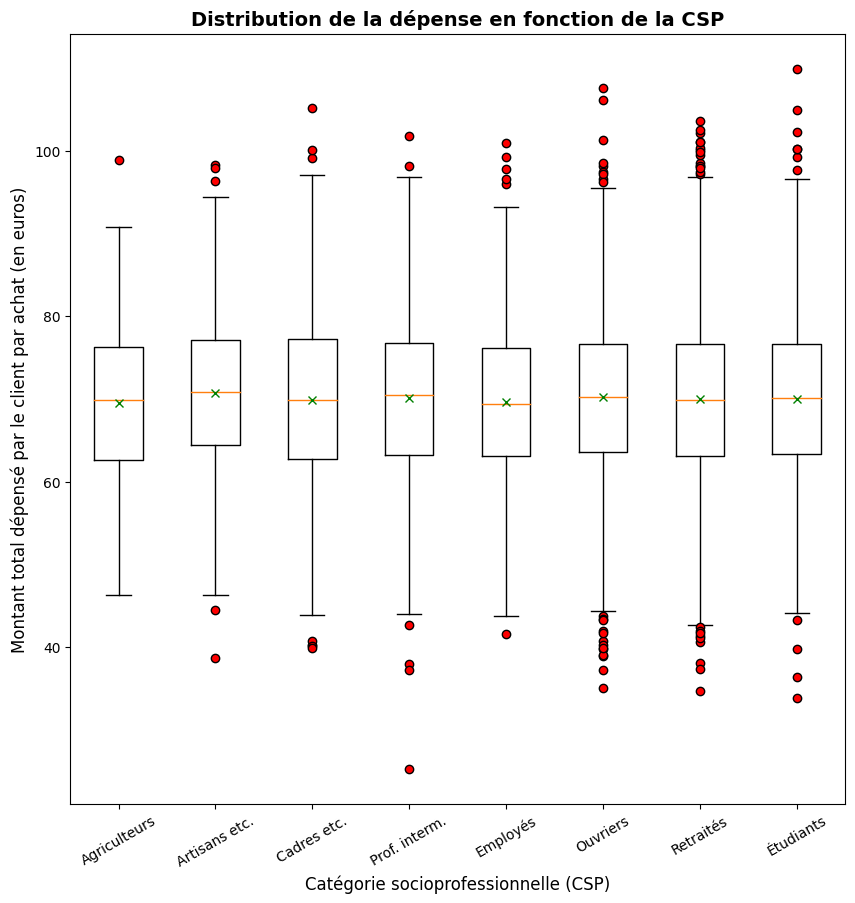

In [13]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize = (10, 10))
ax  = fig.add_subplot(111)
ax.set_title('Distribution de la dépense en fonction de la CSP', fontsize = 14, weight = 'bold')
ax.set

red_circle = dict(markerfacecolor = 'red',   marker = 'o')
mean_shape = dict(markerfacecolor = 'green', marker = 'x', markeredgecolor = 'green')
data = [complete['PRIX'][complete['CSP'] == 'Agriculteur'], complete['PRIX'][complete['CSP'] == 'Artisan et apparentés'], complete['PRIX'][complete['CSP'] == 'Cadre'], complete['PRIX'][complete['CSP'] == 'Profession intermédiaire'], complete['PRIX'][complete['CSP'] == 'Employé'], complete['PRIX'][complete['CSP'] == 'Ouvrier'], complete['PRIX'][complete['CSP'] == 'Retraité'], complete['PRIX'][complete['CSP'] == 'Étudiant']]
ax.boxplot(data, labels = ['Agriculteurs', 'Artisans etc.', 'Cadres etc.', 'Prof. interm.', 'Employés', 'Ouvriers', 'Retraités', 'Étudiants'], showmeans = True, flierprops = red_circle, meanprops = mean_shape)

plt.xticks(rotation = 30)
plt.xlabel('Catégorie socioprofessionnelle (CSP)', fontsize = 12)
plt.ylabel('Montant total dépensé par le client par achat (en euros)', fontsize = 12)
plt.savefig('Distribution de la dépense en fonction de la CSP.pdf')
plt.show()

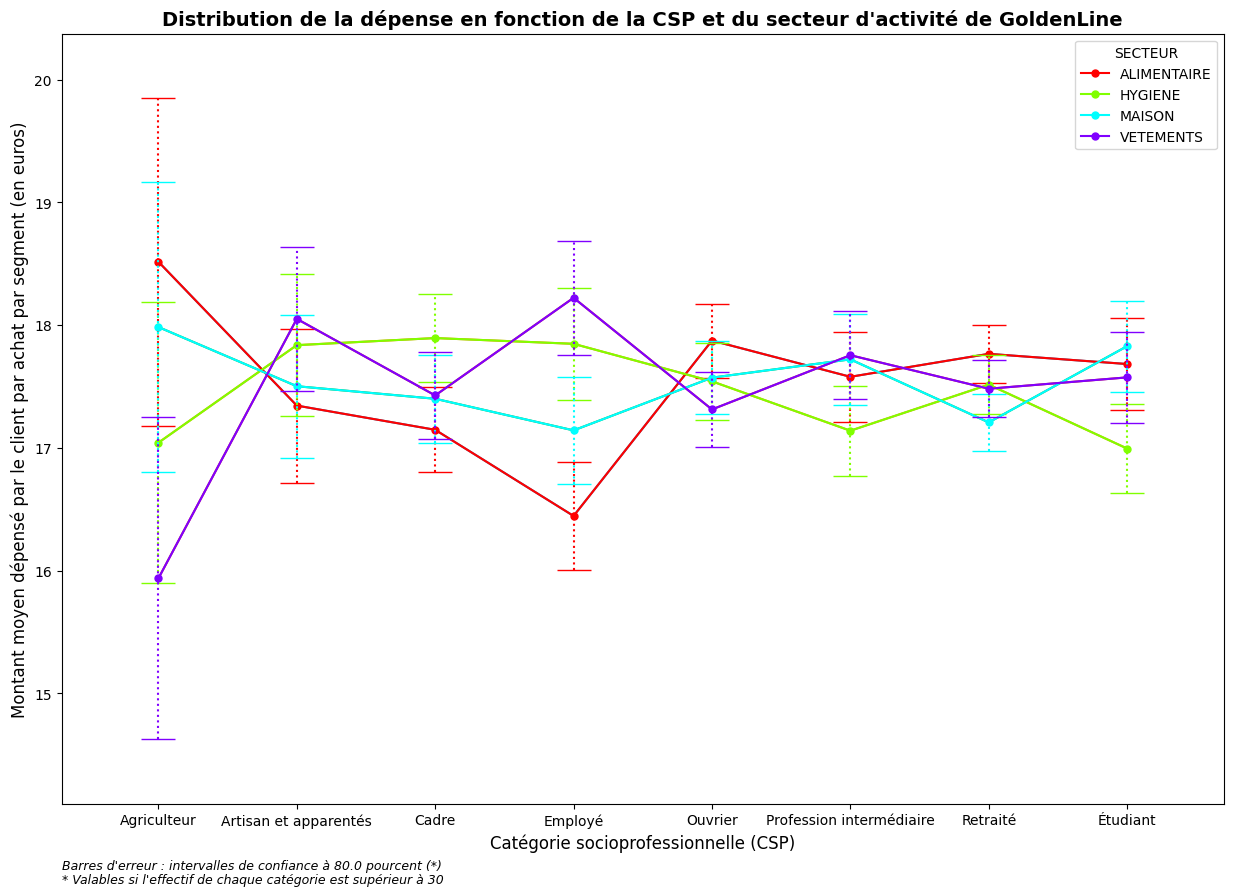

In [14]:
import statsmodels.graphics.utils     as     utils
from   statsmodels.compat.python      import lrange
from   statsmodels.graphics.plottools import rainbow
from   scipy.stats import norm
from   scipy.stats import sem

def int_plot(x, trace, response, func = np.mean, ax = None, plottype = 'b', xlabel = None, ylabel = None, colors = None, markers = None, 
             linestyles = None, legendloc = 'best', legendtitle = None, errorbars = False, conf = 0.95, **kwargs):

    fig, ax       = utils.create_mpl_ax(ax)
    response_name = ylabel      or getattr(response, 'name', 'response')
    ylabel        = '%s of %s' % (func.__name__, response_name)
    xlabel        = xlabel      or getattr(x,        'name', 'X')
    legendtitle   = legendtitle or getattr(trace,    'name', 'Trace')
    x_values      = None
    x_levels      = None
    data          = pd.DataFrame(dict(x = x, trace = trace, response = response))
    plot_data     = data.groupby(['trace', 'x']).aggregate(func).reset_index()
    yerr          = data.groupby(['trace', 'x']).aggregate(lambda xx: norm.ppf((1 + conf) / 2) * sem(xx, ddof = 1)).reset_index()
    n_trace       = len(plot_data['trace'].unique())
    linestyles    = ['-'] * n_trace  if linestyles is None else linestyles
    markers       = ['.'] * n_trace  if markers    is None else markers
    colors        = rainbow(n_trace) if colors     is None else colors

    for i, (values, group) in enumerate(plot_data.groupby('trace')):
        label  = str(group['trace'].values[0])
        if errorbars:
            eb = ax.errorbar(group['x'], group['response'], ecolor = colors[i], capsize = 12, barsabove = True, **kwargs, yerr = yerr.loc[yerr['trace'] == values]['response'].values)
            eb[-1][0].set_linestyle('dotted')
        ax.plot(group['x'], group['response'], color = colors[i], marker = markers[i], label = label, linestyle = linestyles[i], **kwargs)

    ax.set_ylabel(ylabel)
    ax.set_xlabel(xlabel)
    ax.annotate("Barres d'erreur : intervalles de confiance à %s pourcent (*)" %(100 * conf), (0,0), (0, -40), xycoords = 'axes fraction', textcoords = 'offset points', va = 'top', fontsize = 9, style = 'italic')
    ax.annotate("* Valables si l'effectif de chaque catégorie est supérieur à 30",            (0,0), (0, -50), xycoords = 'axes fraction', textcoords = 'offset points', va = 'top', fontsize = 9, style = 'italic')
    ax.legend(loc = legendloc, title = legendtitle)
    ax.margins(.1)
    if all([x_levels, x_values]):
        ax.set_xticks(x_values)
        ax.set_xticklabels(x_levels)
        
    return fig

fig = plt.figure(figsize = (15, 10))
ax  = fig.add_subplot(111)
ax.set_title("Distribution de la dépense en fonction de la CSP et du secteur d'activité de GoldenLine", fontsize = 14, weight = 'bold')
ax.set
int_plot(x = melted_db['CSP'], trace = melted_db['SECTEUR'], response = melted_db['DEPENSE'], ms = 10, ax = ax, errorbars = True, conf = 0.80)

plt.xticks(rotation = 0)
plt.xlabel('Catégorie socioprofessionnelle (CSP)', fontsize = 12)
plt.ylabel('Montant moyen dépensé par le client par achat par segment (en euros)', fontsize = 12)
plt.savefig('Distribution de la dépense en fonction de la CSP et du secteur (avec barres).pdf')
plt.show()

In [15]:
pip freeze > requirements.txt

Note: you may need to restart the kernel to use updated packages.
